**Downloading the RSNA Pneumonia Classification Competition dataset from kaggle**

In [10]:
! pip install kaggle

In [16]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [17]:
! cp kaggle.json ~/.kaggle/

In [18]:
! chmod 600 ~/.kaggle/kaggle.json

In [19]:
! kaggle competitions download rsna-pneumonia-detection-challenge

#kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.65G/3.66G [00:35<00:00, 155MB/s]
100% 3.66G/3.66G [00:35<00:00, 111MB/s]


In [24]:
! unzip rsna.zip

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_trai

**Pre-processing the kaggle dataset**

In [25]:
%pip install pydicom

In [26]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [27]:
labels = pd.read_csv("/content/stage_2_train_labels.csv")

In [28]:
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [29]:
labels = labels.drop_duplicates("patientId")

In [30]:
ROOT_PATH = Path("/content/stage_2_train_images")
SAVE_PATH = Path("/content/preprocessed")

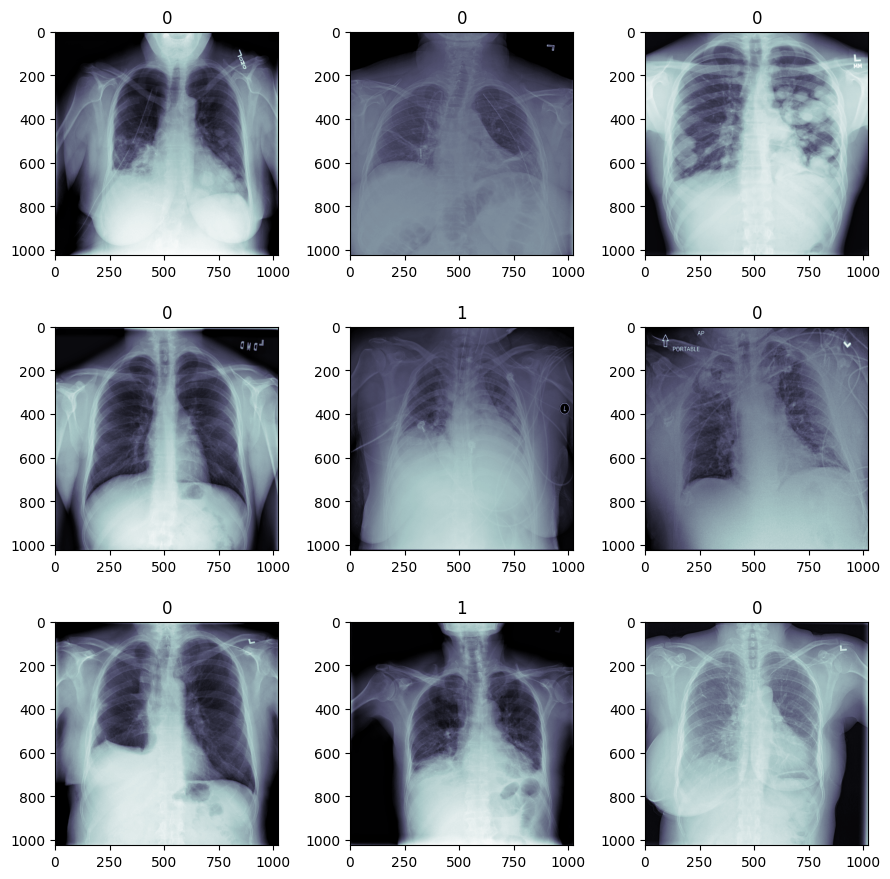

In [31]:
fig = plt.figure(figsize = (9, 9))
axis = fig.subplots(3, 3)

c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")

        try:
            dcm = pydicom.read_file(dcm_path).pixel_array
        except FileNotFoundError:
            print(f"DICOM file not found: {dcm_path}")
            continue

        label = labels["Target"].iloc[c]

        axis[i][j].imshow(dcm, cmap = "bone")
        axis[i][j].set_title(label)
        c+=1

plt.tight_layout()
plt.show()

In [32]:
sums, sums_squared = 0, 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.read_file(dcm_path).pixel_array / 255

    dcm_array = cv2.resize(dcm, (224,224)).astype(np.float16)

    label = labels.Target.iloc[c]

    train_or_val = "train" if c < 24000 else "val"

    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)

    normalizer = 224*224
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array ** 2).sum() / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [33]:
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean ** 2)

In [34]:
mean, std

(0.4903962485384803, 0.24795070634161256)

**Training and Validation Sets Loader**

In [35]:
!pip install torchmetrics
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 5.2 MB/s eta 0:00:00


In [36]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [37]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [38]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees = (-5, 5), translate = (0, 0.05), scale = (0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale = (0.35, 1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248)
])

In [39]:
train_dataset = torchvision.datasets.DatasetFolder("/content/preprocessed/train/", loader = load_file, extensions = "npy", transform = train_transforms)
val_dataset = torchvision.datasets.DatasetFolder("/content/preprocessed/val/", loader = load_file, extensions = "npy", transform = val_transforms)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


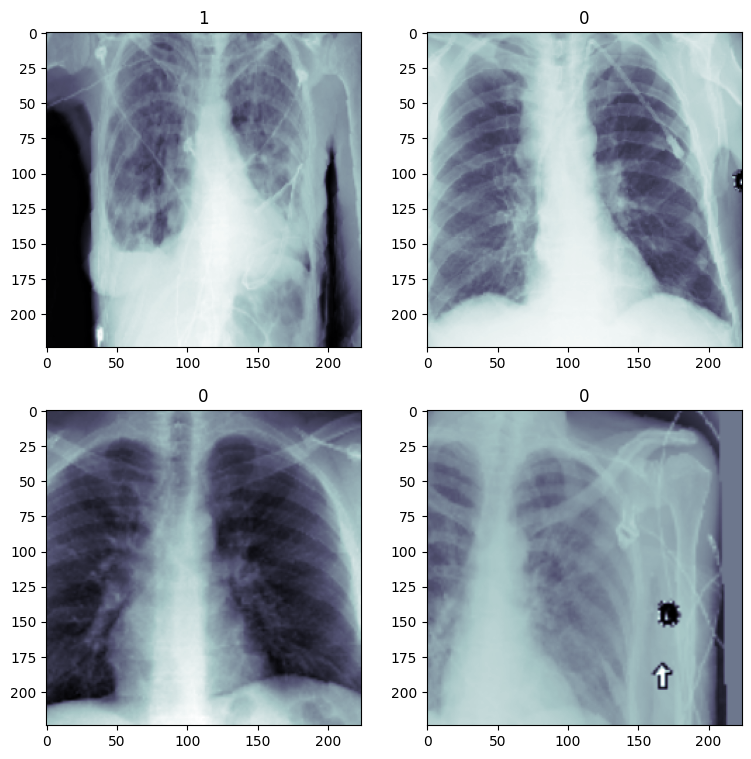

In [40]:
fig, axis = plt.subplots(2, 2, figsize =(9, 9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 24000)
        x_ray, label = train_dataset[random_index]

        axis[i][j].imshow(x_ray[0], cmap = "bone")
        axis[i][j].set_title(label)

In [41]:
batch_size = 32
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

In [42]:
np.unique(train_dataset.targets, return_counts = True)

(array([0, 1]), array([18593,  5407]))

In [43]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
class PneumoniaModel(pl.LightningModule):

    def __init__(self):

        super(PneumoniaModel, self).__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([3]))

        self.train_acc = torchmetrics.Accuracy(task = "binary")
        self.val_acc = torchmetrics.Accuracy(task = "binary")

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)

        self.log("Train Loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))

        return loss

    def on_train_epoch_end(self, outs):
        # Use outs to compute average train accuracy and log it
        avg_train_loss = torch.stack(outs).mean()
        self.log("Train ACC", self.train_acc.compute())
        self.log("Train Loss", avg_train_loss)

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)

        self.log("Val Loss", loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))

    def on_val_epoch_end(self, outs):
        # Use outs to compute average val accuracy and log it
        avg_val_loss = torch.stack(outs).mean()
        self.log("Val ACC", self.val_acc.compute())
        self.log("Val Loss", avg_val_loss)

    def configure_optimizers(self):
        return [self.optimizer]

In [45]:
model = PneumoniaModel()

In [46]:
checkpoint_callback = ModelCheckpoint(
    monitor = "Val_ACC",
    save_top_k = 10,
    mode = "max")

In [47]:
gpus = 1
trainer = pl.Trainer(accelerator = "auto", logger = TensorBoardLogger(save_dir = "/content/logs"), log_every_n_steps = 1,
                    callbacks = checkpoint_callback, max_epochs = 35)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Create a custom callback to handle the outs parameter
class OutsHandler(pl.callbacks.Callback):
    def on_train_epoch_end(self, trainer, model, outs):
        model.on_train_epoch_end(outs)

    def on_validation_epoch_end(self, trainer, model, outs):
        model.on_validation_epoch_end(outs)

# Instantiate the custom callback
outs_handler = OutsHandler()

# Pass the custom callback to the Trainer object's callbacks list
trainer = pl.Trainer(callbacks=[outs_handler])

# Now you can call the fit() method without passing the outs parameter
trainer.fit(model, train_loader, val_loader)

In [48]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TypeError: PneumoniaModel.on_train_epoch_end() missing 1 required positional argument: 'outs'